> This is one of the 100 recipes of the [IPython Cookbook](http://ipython-books.github.io/), the definitive guide to high-performance scientific computing and data science in Python.


# 4.7. Implementing an efficient rolling average algorithm with stride tricks

Stride tricks can be useful for local computations on arrays, when the computed value at a given position depends on the neighbor values. Examples include dynamical systems, filters, cellular automata, and so on. In this example, we will implement an efficient rolling average (a particular type of convolution-based linear filter) with NumPy stride tricks.

The idea is to start from a 1D vector, and make a "virtual" 2D array where each line is a shifted version of the previous line. When using stride tricks, this process does not involve any copy, so it is efficient.

In [1]:
import numpy as np
from numpy.lib.stride_tricks import as_strided
%precision 0

'%.0f'

In [2]:
def id(x):
    # This function returns the memory
    # block address of an array.
    return x.__array_interface__['data'][0]

In [3]:
n = 5; k = 2

In [4]:
a = np.linspace(1, n, n); aid = id(a)

Let's change the strides of `a` to add shifted rows.

In [5]:
as_strided(a, (k, n), (a.itemsize, a.itemsize))

array([[   1e+000,    2e+000,    3e+000,    4e+000,    5e+000],
       [   2e+000,    3e+000,    4e+000,    5e+000,   -5e-312]])

In [6]:
id(a), id(as_strided(a, (k, n)))

(52708824, 52708824)

The last value indicates an out-of-bounds problem: stride tricks can be dangerous as memory access is not checked. Here, we should take edge effects into account by limiting the shape of the array.

In [7]:
as_strided(a, (k, n - k + 1), (a.itemsize,)*2)

array([[ 1.,  2.,  3.,  4.],
       [ 2.,  3.,  4.,  5.]])

Let's apply this technique to calculate the rolling average of a random increasing signal.

First version using array copies.

In [8]:
def shift1(x, k):
    return np.vstack([x[i:n-k+i+1] for i in range(k)])

Second version using stride tricks.

In [9]:
def shift2(x, k):
    return as_strided(x, (k, n - k + 1), (8, 8))

In [10]:
b = shift1(a, k); b, id(b) == aid

(array([[ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.]]), False)

In [11]:
c = shift2(a, k); c, id(c) == aid

(array([[ 1.,  2.,  3.,  4.],
        [ 2.,  3.,  4.,  5.]]), True)

Let's generate a signal.

In [12]:
n, k = 100, 10
t = np.linspace(0., 1., n)
x = t + .1 * np.random.randn(n)

We compute the signal rolling average by creating the shifted version of the signal, and averaging along the vertical dimension.

In [13]:
y = shift2(x, k)
x_avg = y.mean(axis=0)

Let's plot the signal and its averaged version.

In [14]:
%matplotlib inline

In [15]:
import matplotlib.pyplot as plt

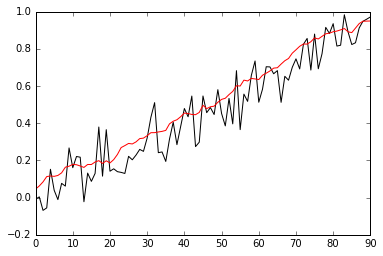

In [16]:
f = plt.figure()
plt.plot(x[:-k+1], '-k');
plt.plot(x_avg, '-r');

### Benchmarks

Let's benchmark the first version (creation of the shifted array, and computation of the mean), which involves array copy.

In [17]:
%timeit shift1(x, k)

The slowest run took 5.71 times longer than the fastest. This could mean that an intermediate result is being cached 
10000 loops, best of 3: 26.3 µs per loop


In [18]:
%%timeit y = shift1(x, k)
z = y.mean(axis=0)

The slowest run took 5.58 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 8.06 µs per loop


And the second version, using stride tricks.

In [19]:
%timeit shift2(x, k)

The slowest run took 4.98 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 9.11 µs per loop


In [20]:
%%timeit y = shift2(x, k)
z = y.mean(axis=0)

The slowest run took 6.60 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 7.71 µs per loop


In the first version, most of the time is spent in the array copy, whereas in the stride trick version, most of the time is instead spent in the computation of the average.

> You'll find all the explanations, figures, references, and much more in the book (to be released later this summer).

> [IPython Cookbook](http://ipython-books.github.io/), by [Cyrille Rossant](http://cyrille.rossant.net), Packt Publishing, 2014 (500 pages).